# Pendahuluan

# Data Preprocessing

In [24]:
# import libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import gc
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier

In [2]:
# import dataset
userData = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")
loan = pd.read_csv("../loan_activities.csv")
nonBorrower = pd.read_csv("../non_borrower_user.csv")
submission = pd.read_csv("../sample_submission.csv")

In [3]:
# memanipulasi data loan activities agar tidak ada lebih dari satu row untuk user_id yang sama
loanBaru = pd.DataFrame()
loanBaru["user_id"] = loan["user_id"].unique()
ts_std = loan.groupby('user_id')['ts'].std().reset_index()
loanBaru = loanBaru.merge(ts_std, on='user_id', how='left')
loanBaru.rename(columns={'ts': 'ts_std'}, inplace=True)
# print(loan.groupby('user_id').value_counts().reset_index()["loan_type"])
loan_type_counts = loan.groupby(['user_id', 'loan_type']).size().unstack(fill_value=0).reset_index()
loanBaru = loanBaru.merge(loan_type_counts, on='user_id', how='left')

loanBaru.head()

,user_id,ts_std,1,2,3,4,5,6,7,8,9,10,11
0,2223129,209.303607,1,0,0,0,1,0,0,0,0,0,0
1,1380939,NaN,1,0,0,0,0,0,0,0,0,0,0
2,2724411,129.326460,1,0,0,0,1,1,0,0,0,0,0
3,2401751,NaN,1,0,0,0,0,0,0,0,0,0,0
4,1982168,251.147367,1,0,0,1,1,0,0,0,0,0,0


In [11]:
# merge data
dataLoan = userData.set_index('user_id').join(loan.set_index('user_id')).reset_index() 
dataLoanBaru = userData.set_index('user_id').join(loanBaru.set_index('user_id')).reset_index()
nonLoan = nonBorrower.set_index('user_id').join(loan.set_index('user_id')).reset_index()
nonLoan = nonLoan.dropna() # orang yang tidak terklasifikasi sebagai peminjam tetapi pernah meminjam

# menambah data frame untuk orang di data train yang pernah meminjam
has_borrowed = dataLoan.dropna()

# EDA

Melihat persebaran fraud dan non fraud untuk setiap kolom

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/948052884.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/948052884.py:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/948052884.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_44

<Figure size 640x480 with 0 Axes>

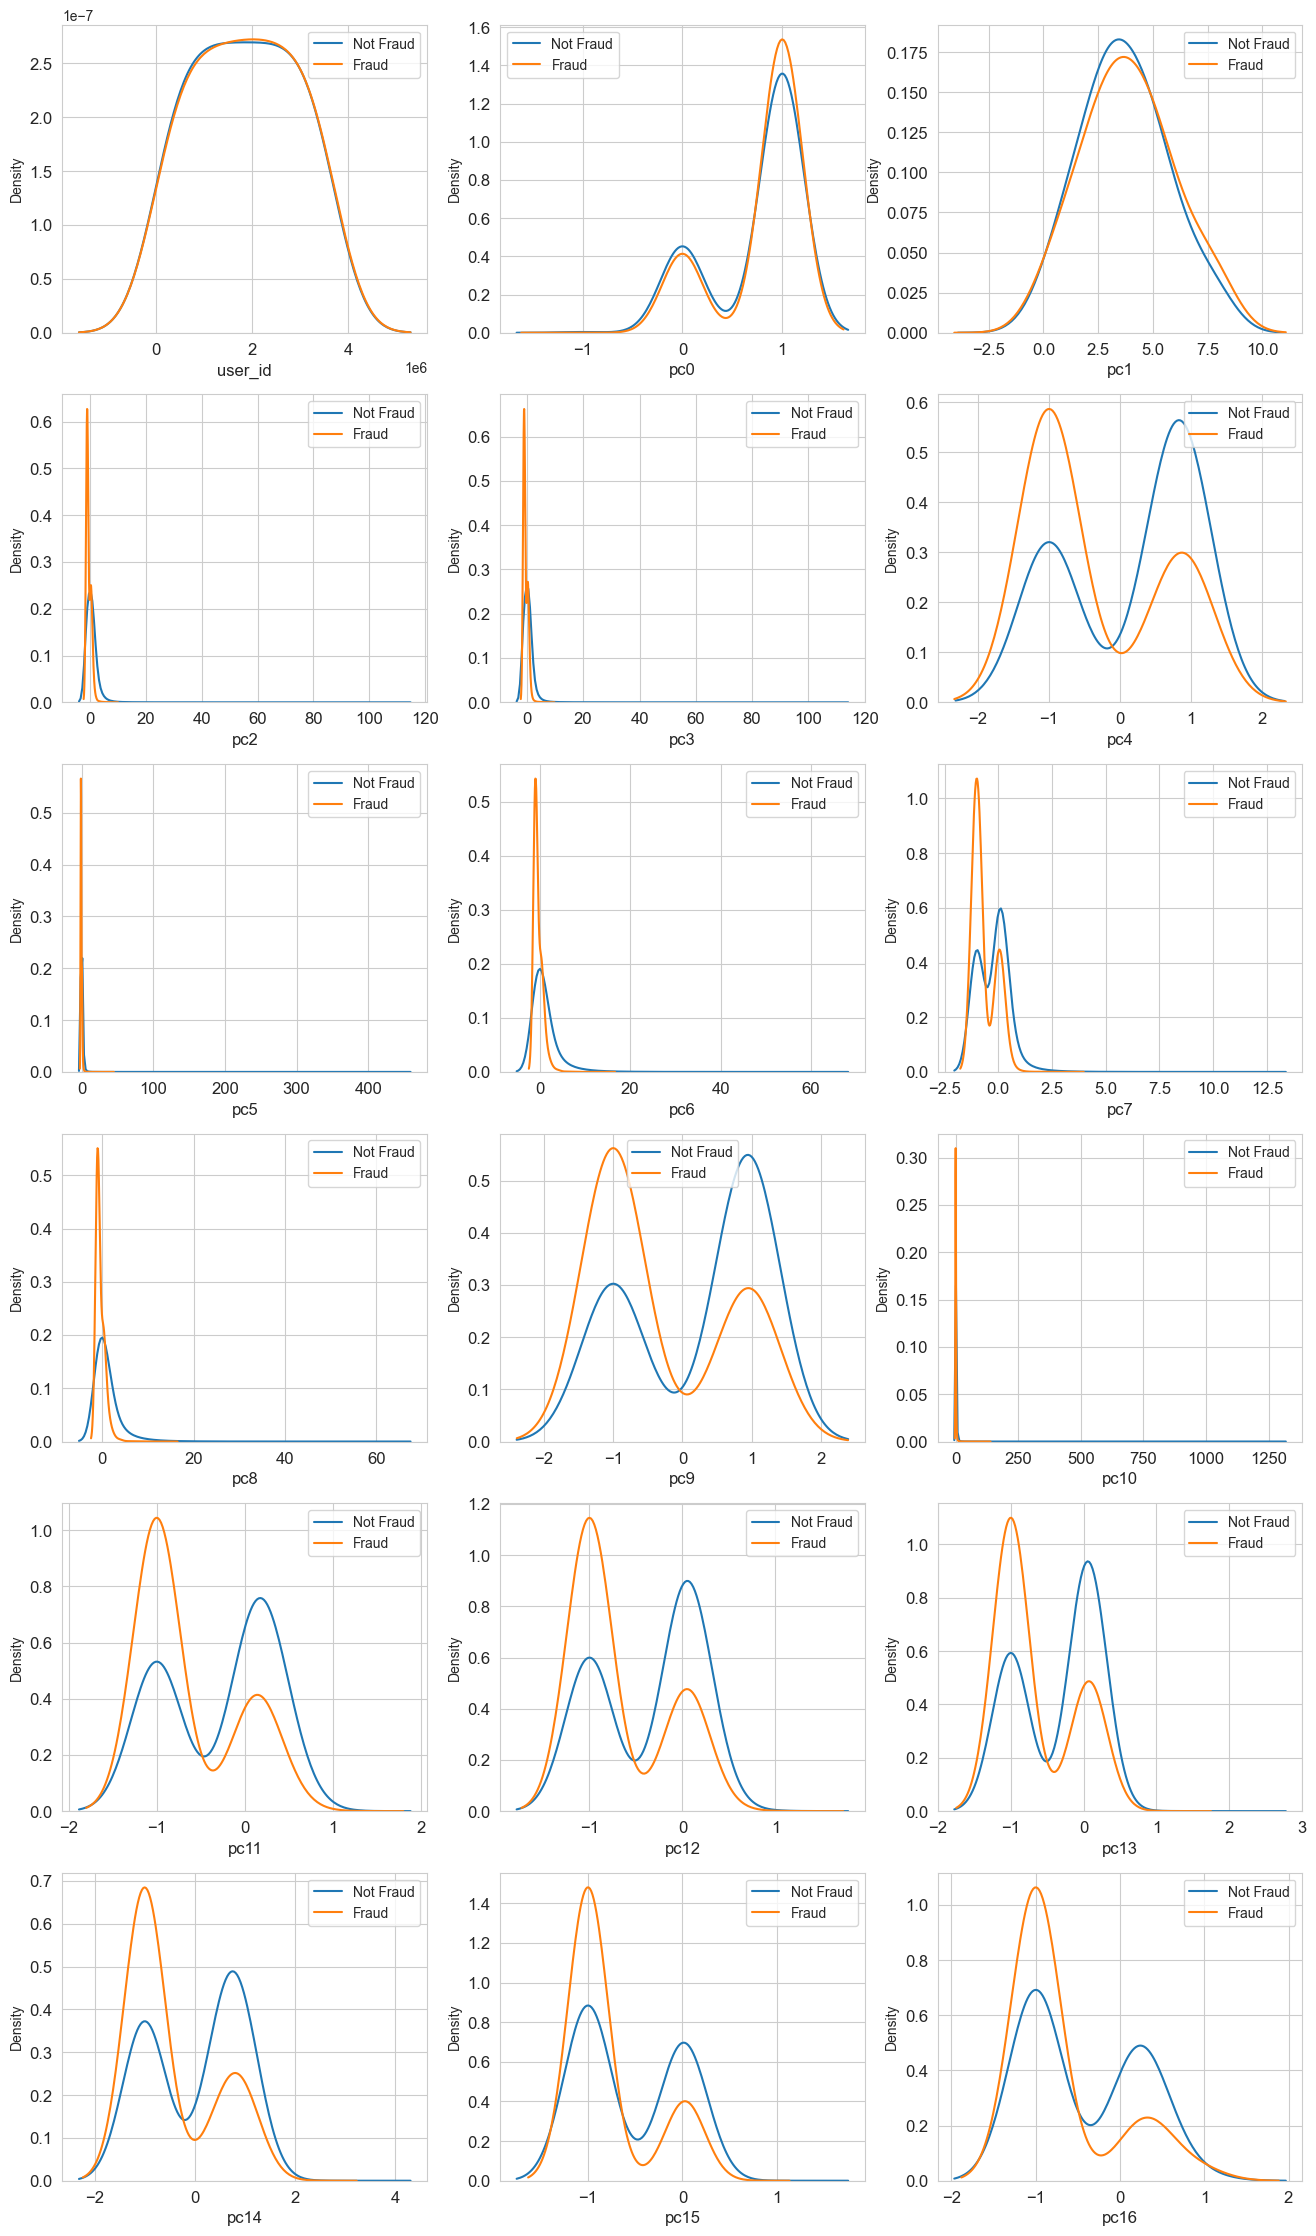

In [4]:
var = userData.columns.values
var = np.delete(var,np.where(var=="label"))

i = 0
t0 = userData.loc[userData['label'] == 0]
t1 = userData.loc[userData['label'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Not Fraud")
    sns.kdeplot(t1[feature], bw=0.5,label="Fraud")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend()
plt.show()

Dari density plot untuk seluruh kolom dapat dilihat bahwa fraud dan non fraud memiliki pola yang berbeda blabla

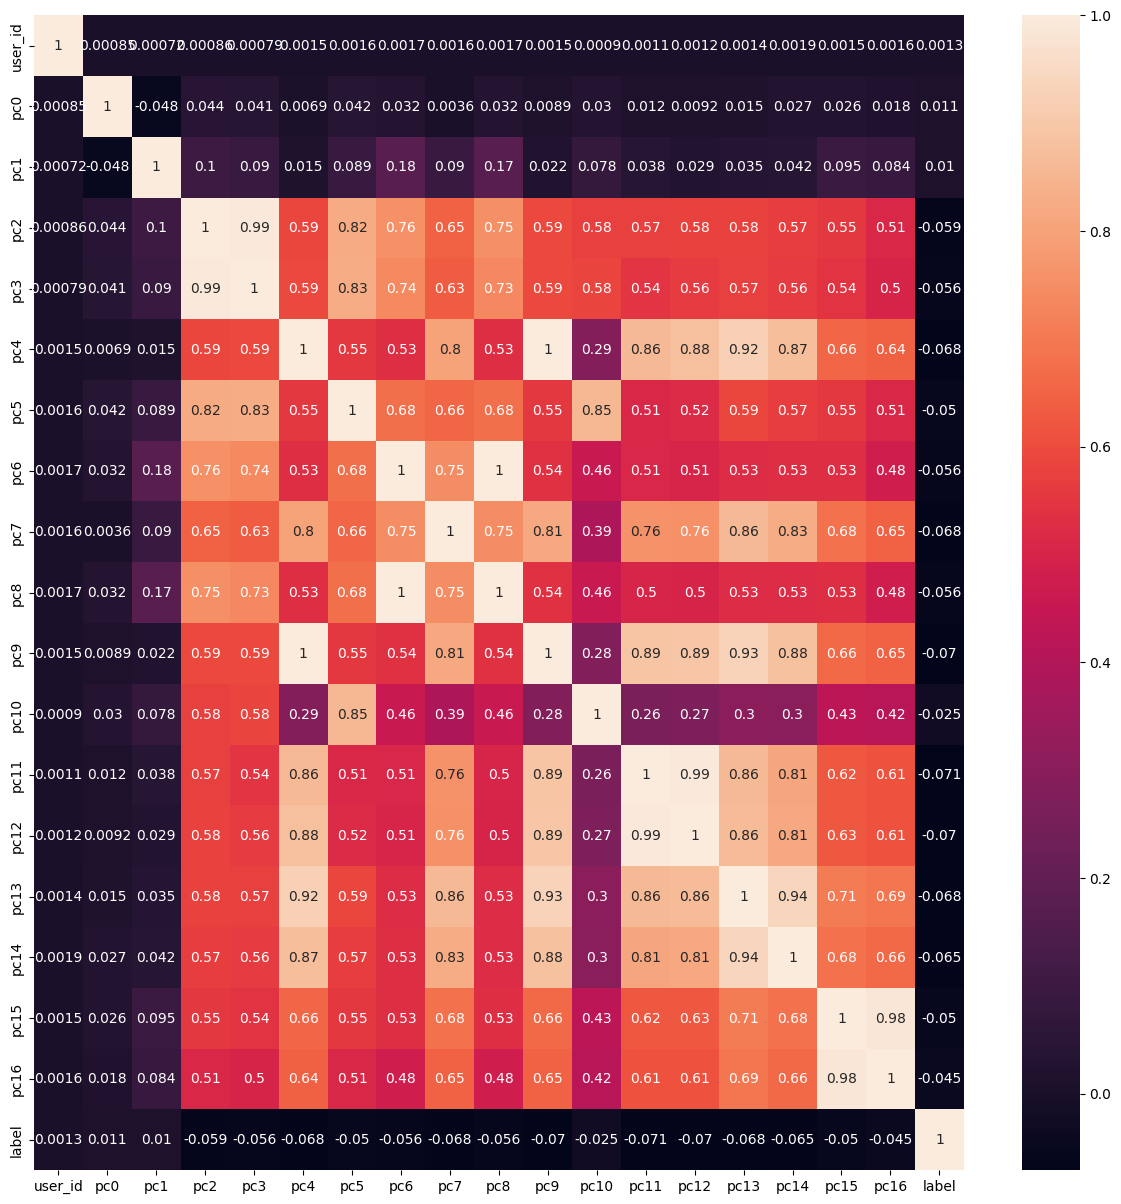

In [5]:
plt.figure(figsize=(15,15))
sns.heatmap(userData.corr(), annot=True)
plt.show()

Heat Map tersebut menunjukan bahwa diantara kolom-kolom pada data train terdapat kolom yang memiliki korelasi 1, yaitu pc4 dengan pc9 dan pc8 dengan pc6. Sehingga kita akan menghapus kolom pc8 dan pc9.

In [6]:
#drop kolom yang sama menurut heatmap
userData = userData.drop('pc8', axis=1) 
userData = userData.drop('pc9', axis=1) 

In [7]:
temp = userData["label"].value_counts()
data = pd.DataFrame({'label': temp.index,'values': temp.values})

trace = go.Bar(
    x = data['label'],y = data['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=data['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'label', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)

iplot(fig, filename='class')

Berdasarkan histogram tersebut, user_id yang melakukan fraud lebih sedikit dengan yang tidak melakukan fraud dengan perbandingan sekitar 1:8

In [8]:
label_0 = has_borrowed.loc[has_borrowed['label'] == 0]["ts"]
label_1 = has_borrowed.loc[has_borrowed['label'] == 1]["ts"]

hist_data = [label_0, label_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Loan Time Stamp Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Density Plot di atas menunjukan bahwa user_id yang melakukan fraud cenderung meminjam pada waktu waktu awal dan user_id dengan label not fraud lebih sering meminjam pada waktu-waktu akhir

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/551677038.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



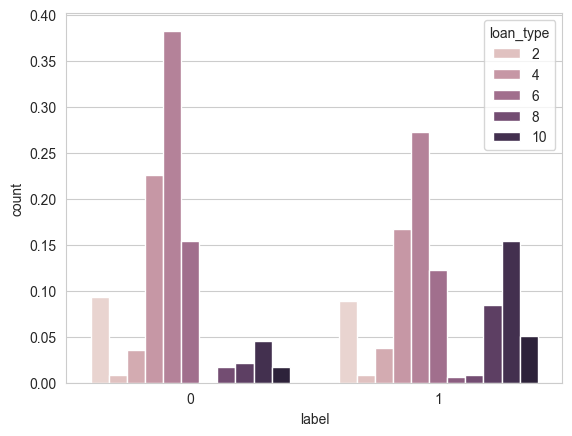

In [9]:
def analysisCategorical(attribute) :
    temp = dataLoan.groupby([attribute, "label"]).count()["user_id"].reset_index()
    temp.rename(columns={"user_id" : "count"}, inplace=True)
    temp["count"] = temp.groupby(["label"], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

    sns.barplot(data= temp, x="label", hue=attribute, y= "count")
    plt.show()

analysisCategorical('loan_type')

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/4032242715.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/4032242715.py:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/4032242715.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel

<Figure size 640x480 with 0 Axes>

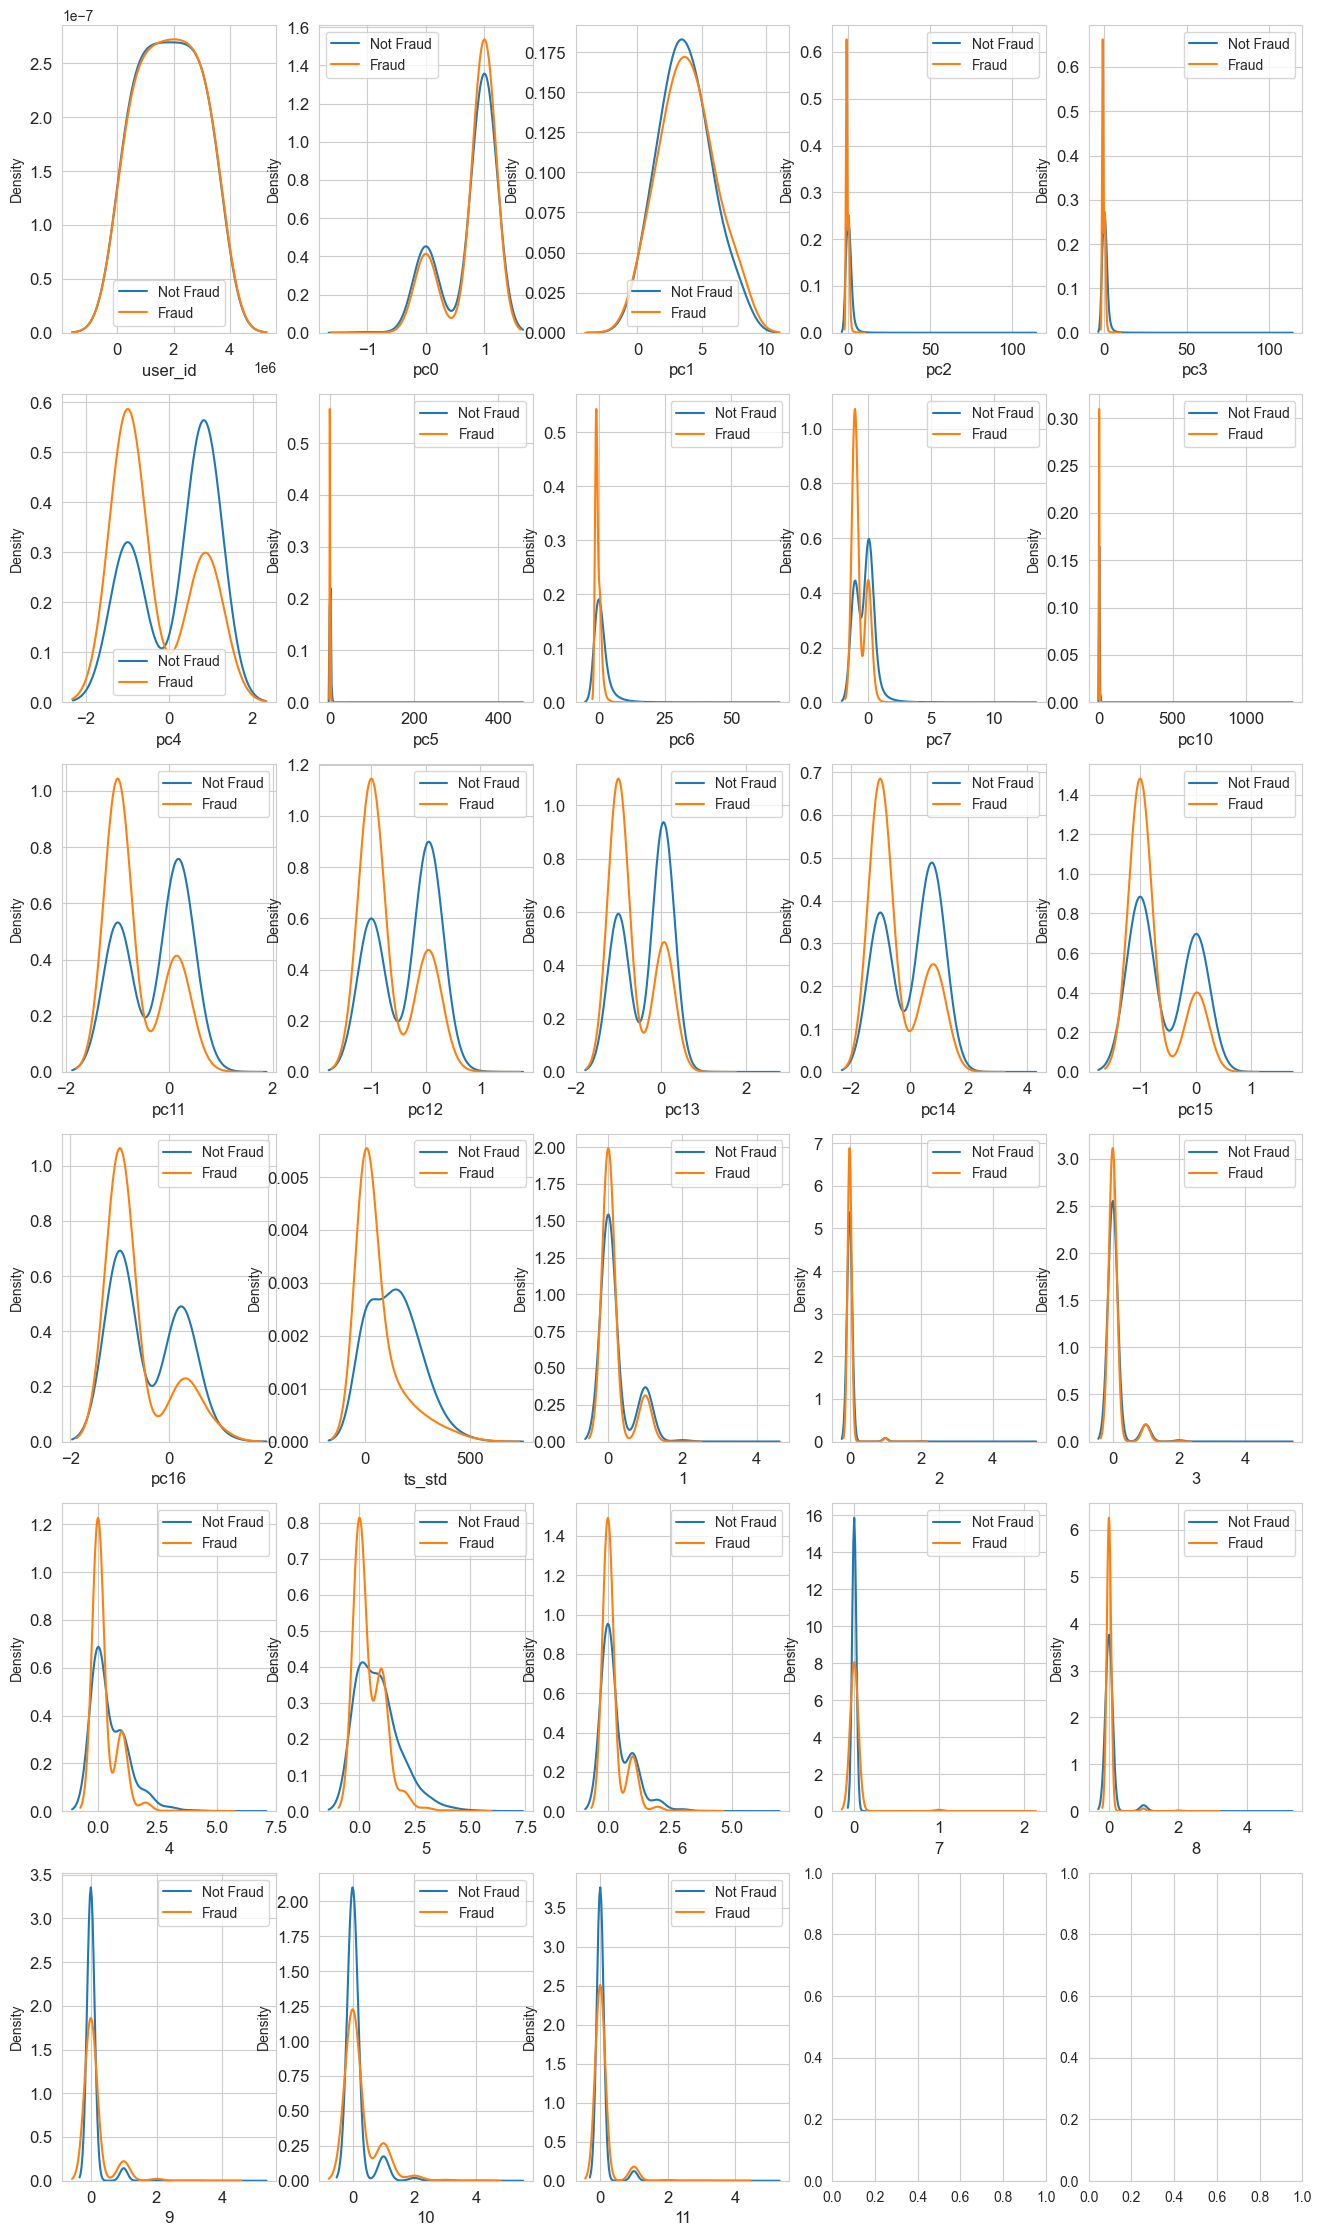

In [12]:
var = dataLoanBaru.columns.values
var = np.delete(var,np.where(var=="label"))

i = 0
t0 = dataLoanBaru.loc[dataLoanBaru['label'] == 0]
t1 = dataLoanBaru.loc[dataLoanBaru['label'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,5,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(6,5,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Not Fraud")
    sns.kdeplot(t1[feature], bw=0.5,label="Fraud")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend()
plt.show()

# Feature Engineering

In [13]:
# menambah kolom
userData['-1_count'] = userData.isin([-1]).sum(axis=1) # menghitung berapa banyak missing values (-1)
userData['is_loanreference'] = userData["user_id"].isin(loan["reference_contact"]) # apakah usernya dijadiin loan reference
userData["has_borrowed"] = userData["user_id"].isin(loan["user_id"]) # apakah usernya pernah minjem
loan["referenced_is_non"] = loan["reference_contact"].isin(nonBorrower["user_id"]) # apakah reference nya non borrower
loan["referenced_is_fraud"] = loan["reference_contact"].isin(userData.loc[userData["label"] == 1]["user_id"]) #nambahin kolom apakah reference nya fraud

In [14]:
dataLoan = userData.set_index('user_id').join(loan.set_index('user_id')).reset_index()
dataLoanBaru = userData.set_index('user_id').join(loanBaru.set_index('user_id')).reset_index()

In [15]:
# menambah kolom loan_count untuk menghitung berapa kali user_id meminjam
dataLoanBaru["loan_count"] = dataLoanBaru.iloc[:, 21:].sum(axis=1)

In [16]:
# memisahkan data fraud dan non fraud
loanFraud = dataLoan.loc[dataLoan["label"]==1]
loanFraud = loanFraud[["user_id", "reference_contact", "loan_type", "ts"]]
loanNonFraud = dataLoan.loc[dataLoan["label"]==0]
loanNonFraud = loanNonFraud[["user_id", "reference_contact", "loan_type", "ts"]]

In [21]:
# menambah data frame baru yang berisi info mengenai kontak referensi

referenceInfo = pd.DataFrame()
referenceInfo["user_id"] = pd.concat([userData["user_id"], (nonBorrower["user_id"]),(test["user_id"])])
referenceInfo["referenced_by_fraud"] = referenceInfo["user_id"].isin(loanFraud["reference_contact"])
referenceInfo["referenced_by_non"] = referenceInfo["user_id"].isin(loan.loc[loan.user_id.isin(nonBorrower.user_id)]["reference_contact"])
referenceInfo["referencing_fraud"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_fraud"] == 1]["user_id"])
referenceInfo["referencing_non"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_non"] == 1]["user_id"])

In [19]:
#nyari rata rata ts_std
# meanStdFraud = dataLoanBaru[~dataLoanBaru["ts_std"].isnull() & dataLoanBaru["label"] == 1]["ts_std"].median()
# meanStdNonFraud = dataLoanBaru[~dataLoanBaru["ts_std"].isnull() & dataLoanBaru["label"] == 0]["ts_std"].median()
# medianStd = loanBaru["ts_std"].median()
# print(medianStd)

In [22]:
# data frame yang akan digunakan untuk modelling

trainLoanReference = dataLoanBaru.set_index('user_id').join(referenceInfo.set_index('user_id')).reset_index() #nyatuin data train sama loan
trainLoanReference.columns = trainLoanReference.columns.astype(str)


trainLoanReference.loc[(trainLoanReference["loan_count"] == 0), "ts_std"] = -1
trainLoanReference.loc[(trainLoanReference["loan_count"] == 1), "ts_std"] = 0

trainLoanReference.fillna(0, inplace=True)

# Modelling

In [25]:
droppedLabels = ["label", "user_id"]#, "11", "10", "9", "7", "3", "2", "1", "pc1", "pc0"]#, "referenced_by_fraud", "referenced_by_non", "referencing_fraud", "referencing_non", "is_loanreference", "has_borrowed"]

X = trainLoanReference.drop(droppedLabels, axis = 1, errors= ['ignore'])
y = trainLoanReference['label']
# X = dataLoan.drop(["user_id", "label", "loan_type",], axis = 1)
# y = dataLoan['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [26]:
randomForest = RandomForestClassifier(n_jobs= -1, 
                                      random_state=42, 
                                      class_weight="balanced", 
                                      min_samples_leaf=15,
                                      n_estimators=1000)
# Train the model
randomForest.fit(X_train, y_train)

# Predict
# predict = pd.Series(clf.predict(X_test), index = X_test.index)
predictRandomForest = randomForest.predict(X_test)

In [27]:
average_precision_score(y_test.values, predictRandomForest)

0.026873512133880464

- default = 0.02528770208180763
- min sample leaf 5 = 0.025436238446531808
- min sample leaf 10 = 0.02544918516250045
- min sample leaf 15 = 0.025460922616243723
- IDEAL KAYA HMM = 0.4020140009484878

Melihat Performa Model

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_4442/2248248613.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



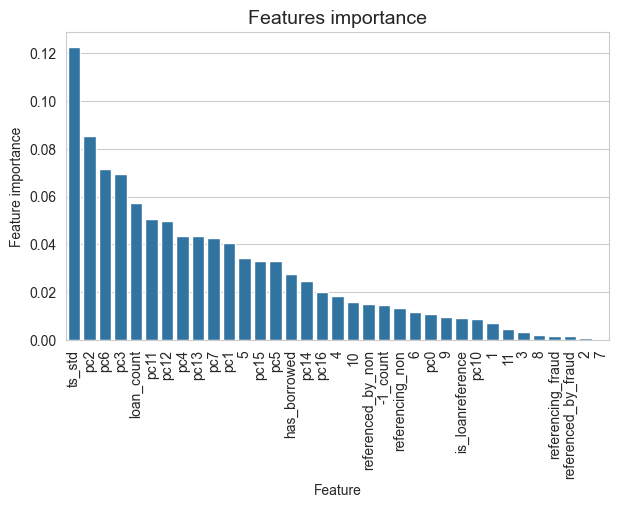

In [28]:
tmp = pd.DataFrame({'Feature': X_train.columns.values, 'Feature importance': randomForest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

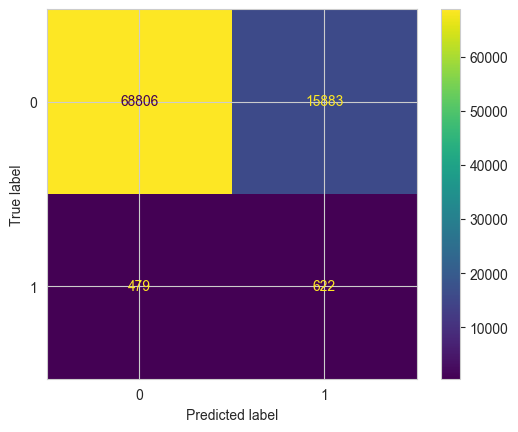

In [29]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predictRandomForest)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [40]:
#make a submission
test['-1_count'] = test.isin([-1]).sum(axis=1) # menghitung berapa banyak missing values (-1)
test['is_loanreference'] = test["user_id"].isin(loan["reference_contact"]) # apakah usernya dijadiin loan reference
test["has_borrowed"] = test["user_id"].isin(loan["user_id"]) # apakah usernya pernah minjem
test = test.drop(['pc8','pc9'], axis=1, errors= 'ignore')

testLoan = test.set_index('user_id').join(loanBaru.set_index('user_id')).reset_index()
# menambah kolom loan_count untuk menghitung berapa kali user_id meminjam
testLoan["loan_count"] = testLoan.iloc[:, 20:].sum(axis=1)

testLoanReference = testLoan.set_index('user_id').join(referenceInfo.set_index('user_id')).reset_index()
testLoanReference.columns = testLoanReference.columns.astype(str)

testLoanReference.loc[(testLoanReference["loan_count"] == 0), "ts_std"] = -1
testLoanReference.loc[(testLoanReference["loan_count"] == 1), "ts_std"] = 0
testLoanReference.fillna(0, inplace=True)  

In [31]:
# Train the model
randomForest.fit(X, y)

# Predict
# predict = pd.Series(clf.predict(X_test), index = X_test.index)
predictRandomForest = randomForest.predict(testLoanReference)

KeyboardInterrupt: 

In [ ]:
submission['label'] = predictRandomForest

In [ ]:
#export to csv
submission.to_csv('submission4.csv', index=False)